# Homework 4 - Code Search using Deep Learning Bi-Encoders

Modern search engines are capable of working with more than just text: images, videos, audio, songs, ... the list goes on and on! In Homework 4, you'll develop an IR system that works in two modalities: text queries and _code_ documents. Code may be written in text characters (it's human readable, unlike image files) but queries like ``python function to test if file exists`` may look nothing like the code that matches the query's intent.

To bridge these two languages, we'll use a relative recent technique known as a *bi-encoder* model to convert text queries and code documents into the same representation space. If you recall from class, our tf-idf vectorizer was an encoder—-it would convert some text query into a high-dimensional vector, _encoding_ the text into some numeric space. Here, we'll use deep learning encoders that also produce numeric vectors. However, unlike our tf-idf vectors which are large (the size of the vocabulary) and sparse (most queries don't have most words), our deep learning-produced vectors will be relatively small (hundreds of dimensions) and dense (all dimensions have a non-zero value). 

For text, most of the common deep learning models are similar to the **BERT** model we talked about in class during the deep learning week. If you recall, this was the model that was trained using a MadLibs-style approach where it's shown most of a sentence and asked to fill in the blanks for a few words that have been removed. This type of training lets the model ultimately produce a dense vector representation for the "meaning" of a text input--essentially acting as a text encoder. If you're curious, there are a few [good](https://huggingface.co/blog/bert-101) [tutorials](https://wandb.ai/mukilan/BERT_Sentiment_Analysis/reports/An-Introduction-to-BERT-And-How-To-Use-It--VmlldzoyNTIyOTA1) on what this model is all about, though you don't need to know it for the purposes of this assignment. The most relevant thing to know is that other folks have adapted this approach to produce other models that can encode the meanings of other kinds of input, _like code_.

<img src="https://weaviate.io/img/blog/cross-encoders/bi-encoder.png" alt="drawing" width="200"/>

The bi-encoder architecture (shown above for two _sentence_ inputs) use two of these deep learning encoder models to compare the encodings of each model's input in some way. Here, we'll compare an encoded query and an encoded-code-document to measure the IR _relevance_ of that document for the given query. The bi-encoder setup lets us bridge between the two languages by _training the model to adjust its representations_. The key idea here is that both encoders know how to represent each of their respective inputs (they've already been pre-trained to do this) and by further training, we can get the encoders to adjust how they represent things so that representations for very relevant query-document papers look similar and representations for non-relevant pairs look dissimilar.

### Homework summary

This homework provides a substantial amount of code to get you started and has you focus on just a few implementation pieces.

* **Part 1** of the homework will be training the bi-encoder model. You will need a GPU for this, so you'll want to run this on a Great Lakes machine with a GPU. We've done testing and set the hyperparameters below so that it should run quickly enough. _But_ it will still take an hour to complete training once you get it up and running. Once you have the model trained, you'll export the query-document relevance scores from the bi-encoder to a file for use later.

* **Part 2** will have you learning how to do Learning to Rank (L2R) again and incorporating the bi-encoder's predictions. For this part, you will need to have access to Java to run Pyterrier. However, you will not need a GPU and this part can be run either on a non-GPU Great Lakes machine or on your local machine. You will still need access to the outputs of the bi-encoder which are in a file, so if you work locally, you'll need to copy those still. Part 2 will show you how to set up new pipelines that make use of precomputed features.

For both parts, we've put in extensive comments throughout so you can get a sense of what is happening and why. You don't need to understand all of the code, but it will be helpful to try to understand the general flow of things and how you train these kinds of models at a high level (possibly relating to questions on the final exam).

### Implementation Notes 

This notebook contains a lot of code that is intended to expose you to various deep learning concepts _but_ where you don't need to modify it. To streamline the process, we've put even more low-level code into two files that you don't need to read: 

- **edited_roberta.py** contains the pre-trained RoBERTa model architecture.
- **run_classifiers.py** contains the some helpful scripts for running things and loading data.

If you've never seen PyTorch code, that's ok (and expected!). We've added detailed instructions on what you need to know or learn in each step. Your pytorch code will be very (_very_) minimal, but we do want you to try a few things. There are also many good tutorials out there for pytorch _but_ these tutorial cover more information than what is needed too, so please read judiciously so you don't feel overwhelmed. If you do decide to read more, perhaps one general place to start is tutorials on using PyTorch for [logistic regression](https://towardsdatascience.com/logistic-regression-with-pytorch-3c8bbea594be).


### What to do

For Part 1, we've marked your parts with TODO. To get a sense of what and why you're doing something, be sure to read the nearby parts of the notebook for context. 

In general, you will need a GPU to run this. However, we've provided a very tiny input file `data/train_10.txt` that has only 10 training examples. Training only on this file will produce horrible results. _However_ it is small enough that you can probably run the code on a CPU to start debugging, though this may take a lot of memory. Worst case, you can start and debug this file on a Great Lakes machine (without a GPU) and once you think it's working, switch to a GPU.


### Learning goals for Part 1 of Homework 4:
* Expose you to how to run and train deep learning systems
* Gain familiarity with bi-encoder models for IR with different modalities
* Learn how to read and import data for training bi-encoder models
* Learn how to export relevance predictions from deep learning models for use in IR ranking systems


In [1]:
from edited_roberta import *
from run_classifier import evaluate, load_and_cache_examples, accuracy, set_seed
import argparse
import glob
import logging
import os
import random
import numpy as np
import torch
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)
from torch.utils.data.distributed import DistributedSampler
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm, trange
from transformers import (WEIGHTS_NAME, get_linear_schedule_with_warmup, AdamW,RobertaConfig,RobertaTokenizer)
from utils import (compute_metrics, convert_examples_to_features,
                        output_modes, processors)

import pandas as pd

from torch.nn.functional import cosine_similarity

logger = logging.getLogger(__name__)

2022-12-06 12:53:05.570043: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-06 12:53:05.826366: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-06 12:53:05.830458: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /sw/pkgs/arc/openjdk/jdk-18.0.1.1/lib:/opt/slurm/lib64::
2022-12-06 12:53:05.830483

# Defining our Bi-Encoder model

In the following block, we'll create our neural network bi-encoder model. To do so, we'll define a new class `CodeSearchBiencoderModel` that contains the two encoders, which are the encoder for query and the encoder for code. 

In pytorch, neural networks are defined by specifying their _parameters_ (the things that get updated during training) and a `forward` function that determines how to turn the inputs into outputs. For our bi-encoder, we'll need to fill these in as follows:

* Specify the two encoders in the `__init__` function as fields of the class (e.g., `self.x = 1` makes `x` a field of the object), which will tell PyTorch that we'll be updating their parameters during training
* Write the `forward` function so that we...
  * encode the query as a vector
  * encode the code-document as a vector
  * compute the cosine similarity of the two vectors (where 1 is relevant, 0 is not-relevant)
  
We'll detail these next.

## Creating the encoders

How do we instantiate an encoder? There are two steps. First we need to figure out what is the _architecture_ of the model. This defines things like how many layers are in a neural network and how the layers are connected. In our case, _both_ of our encoders will use the RoBERTa architecture; as you might have guessed, RoBERTa is related to BERT and just has slightly different tweaks. There are [many BERT variants](https://towardsdatascience.com/exploring-bert-variants-albert-roberta-electra-642dfe51bc23) and for the purposes of this excise, you can safely think of RoBERTa as the same as BERT.

Second, once we have our model architecture, we need to specify which parameters we'll start with. You can think of the difference between the model architecture and parameters as if you were specifying a meal: The architecture is a bit like specifying the plates/bowls/container based on what kind of food you want and the parameters are like filling the container with a specific kind of food. There are many pre-trained sets of parameters for architectures, so a neural network starts with some existing knowledge of certain kinds of things (e.g., what human  language looks like,  what programming languages look like, or how to classify images). In neural network land, the [Huggingface Model Repository](https://huggingface.co/models) is a common place to look for parameters that people have shared with others.

Returning to our IR problem, in our setting (conveniently), both of our encoders will use the same architecture: `RobertaModel`. If you _really_ want to know more, the code for this is provided in `edited_roberta.py`, but many end-users of these models (like us) will never need to look at this kind of code--and you certainly don't to complete this homework!

## Writing the forward function 

The `forward` function defines how the neural network goes from inputs to outputs. In our case, we're going to feed the different inputs (query and document) to separate encoders and then compare the outputs. 


Your task here:
1. Define the two encoders(query encoder and code_encoder) which are RobertaModel loaded from edit_roberta.py. You should two arguments when creating the instance of the Roberta Model, which are config and add_pooling_layer(equal to False).
2. define and calculate the cosine similarity between two embeddings.
3. define the loss function and loss.

### TODOs in this block are worth 20 points total

In [2]:
class CodeSearchBiencoderModel(RobertaPreTrainedModel):

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.config = config

        ## TODO: 
        # Fill in the following parts where you specify each encoder's architecture. 
        # You'll need to pass in "config" as an argument to the architecture's constructor
        # so it knows how to set things up.
        #
        # NOTE 1: Notice that we haven't specified the *parameters* here, just the architecture.
        # We'll fill in the parameters later
        #
        # NOTE 2: If you were ever curious how to do other kinds of non-text IR (e.g., images),
        # this part is where you'd specify a different kind of encoder architecture, such as
        # ResNet50 for encoding images. The rest of the code for this class would be mostly the same!
        # (The one caveat is that both models need to produce vector representations of the same size)
        
        self.query_encoder = RobertaModel(config,add_pooling_layer = False)
        self.code_encoder = RobertaModel(config,add_pooling_layer = False)

        # This is our loss function that determines how "good" our model's output is.
        # We'll use this in the forward() function to evaluate the model's outputs and
        # then return the predictions and loss.        
        self.loss_fn = BCEWithLogitsLoss()
        
        # This will initialize weights and apply final processing
        self.post_init()
 
    def forward(
        self,
        query_token_ids: Optional[torch.LongTensor] = None,
        code_token_ids: Optional[torch.LongTensor] = None,
        attention_mask: Optional[torch.FloatTensor] = None,
        labels: Optional[torch.LongTensor] = None,
       
    ) -> Union[Tuple[torch.Tensor], SequenceClassifierOutput]:
        r"""
        labels (`torch.LongTensor` of shape `(batch_size,)`, *optional*):
            Labels for computing the sequence classification/regression loss. Indices should be in `[0, ...,
            config.num_labels - 1]`. If `config.num_labels == 1` a regression loss is computed (Mean-Square loss), If
            `config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        """
       

        outputs = self.query_encoder(
            query_token_ids,
            attention_mask=attention_mask,
        )
        query_emb = outputs[0][:, 0, :]
        
        outputs_code = self.code_encoder(
            code_token_ids,
            attention_mask=attention_mask,
        )
        code_emb = outputs_code[0][:, 0, :]

        # TODO: using the cosine_similarity function (imported above),
        # compute the similarity of the query and code embeddings.
        # ref: RobertaForSequenceClassification
        cosine_sim = cosine_similarity(query_emb, code_emb)
                       
        # TODO: use the self.loss_fn (our loss function) to measure how good/bad
        # the predictions are. This function will return a value you should 
        # call "loss". You can see how to call the function here
        # https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html
        # 
        # NOTE: The "labels" input to this function is the ground truth
        # relevance scores (labels) for each input. You'll want to compare
        # the cosine similarities with these labels when calling the function
        #
        # NOTE 2: There are many kinds of loss functions so understanding how
        # to call them and which order the arguments go in is important
#         loss = self.loss_fn(cosine_sim, labels)
        loss = self.loss_fn(cosine_sim.squeeze(), labels.squeeze())

        # Finally, let's return some output! Pytorch has provided
        # some structure for us to say what-is-what in the output
        # values. We'll return our loss (how "bad" the model's prediction was)
        # and the logits, which is our predictions. 
        #
        # You don't need to worry about the other two outputs.
        #
        # NOTE: Normally, we'd be passing the cosine similarity through
        # some non-linear function (like a sigmoid!) to get "logits" as
        # our output values. However, in a bi-encoder, often you just 
        # return the cosine similarity as the logits, so the name is wrong
        # but the value is what's expected. Later on, when we access the
        # "logits" part of the output, remember these are the query-doc
        # cosine similarity scores
        return SequenceClassifierOutput(
            loss=loss,
            logits=cosine_sim,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

# Configure the Models and Training Setting

Training deep learning models often involves _lots_ of hyperparameter decisions--not to mention a bunch of seemingly-random bookkeeping options for where and when to save things. We have defined these all for you (yay) but it's worth at least looking through to see what kinds of decisions you'll need to make. Most importantly, we've specified the number of epochs and the batch size (more on that later) so that the model trains quickly.

You will eventually need to edit the input file name to use the full dataset. Everything else can stay the same, though you're welcome to try changing some things and seeing what happens once you've completed the assignment.

In [3]:
class Args:
    def __init__(self):
        
        # Where to save things
        self.data_dir = './data'
        self.model_type = 'roberta'
        self.model_name_or_path = 'microsoft/codebert-base'
        self.task_name = 'codesearch'
        self.output_dir = './models'
        self.output_mode = 'codesearch'

        # These are going to be your most common hyperparameters to change.
        # If you want to do deep learning stuff, it's worth learning a bit
        # about what they are and what they do.
        self.train_batch_size = 64
        self.eval_batch_size = 64
        self.gradient_accumulation_steps = 1
        self.learning_rate = 1e-5
        self.weight_decay = 0.0
        self.adam_epsilon = 1e-8
        self.max_grad_norm = 1.0
        self.num_train_epochs = 3 # NOTE: Change this to 1 if debugging so it runs faster
        self.max_steps = -1
        self.warmup_steps = 0
        self.n_gpu = 1
        self.no_cuda = False

        # These are mostly configuration options for which pieces to run
        self.config_name = ""
        self.tokenizer_name = ""
        self.cache_dir = ""
        self.max_seq_length = 200
        self.do_train = True
        self.do_eval = True
        self.do_predict = False
        self.evaluate_during_training = False
        self.do_lower_case = False

        # How often we save things
        self.logging_steps = 1000
        self.save_steps = 1000
        self.eval_all_checkpoints = False
        self.overwrite_output_dir = True
        self.overwrite_cache = True
        self.seed = 42
        
        # Ignore all of these
        self.fp16 = False
        self.fp16_opt_level = 'O1'
        self.local_rank = -1
        self.server_ip = ""
        self.server_port = ""
        
        # Input and output files.
        #
        # TODO: Change the training file to train_300k.txt when ready
        #
        self.train_file = "train_300k.txt" # CHANGE ME WHEN READY TO TRAIN!!!!!
        self.dev_file = "valid.txt"
        self.test_file = "test_data.txt"
        self.pred_model_dir = './models/checkpoint-best'
        self.test_result_dir = './results/'

args = Args()

In the following blocks, we are starting to train our model. Here we will firstly define the train function.

In the train function, we will define the procedure of training the model, the main steps are:
1. Define the dataloader (to do). You should use the function DataLoader(). Three arguments are required for you to input, which are dataset, batch_size, sampler.
2. set the gradient to zero and train the model using back propagation.


# Define the training process

Let's see how the training procedure works! The code block below specifies how we'll train our model. There's one part for you to fill in that loads the data using the `DataLoader` class. The rest is helpful to understand how 

### TODO in this block is worth 10 points

In [4]:
def train(args, train_dataset, model, tokenizer, optimizer):
    """ Train the model """

    # The sampler specifies how we should access the training data, which
    # in this case is in a random order
    train_sampler = RandomSampler(train_dataset)
    
    # TODO: Initailize the DataLoader (https://pytorch.org/docs/stable/data.html)
    # so that it 
    # - loads from the provided train_dataset 
    # - samples using our sampler
    # - uses the specified batch size
    #
    # NOTE: The batch size is pretty important! This says how many examples to train on 
    # at one time. If you recall, we talked about Stocastic Gradient Descent (SGD) that
    # updates based on one instance at a time (e.g., changing the dog t-shirt size after seeing one dog)
    # versus Gradient Descent (GD) that updates after all the data. SGD is much faster to
    # converge to the "right" parameters but can make many missteps. The batch size 
    # says we can look at more than one instance at a time in determining how to update
    # our parameters (e.g., look at a few dogs at a time to determine how to best update 
    # the t-shirt size, rather than just one dog or all the dogs)
    train_dataloader = DataLoader(dataset=train_dataset, batch_size=args.train_batch_size, sampler=train_sampler)
    
    # How many total steps we'll take
    t_total = len(train_dataloader) //  args.num_train_epochs

    # The scheduler helps decide how quickly to update the weights based on how much
    # training data we've seen. 
    scheduler = get_linear_schedule_with_warmup(optimizer, args.warmup_steps, t_total)
    checkpoint_last = os.path.join(args.output_dir, 'checkpoint-last')
    scheduler_last = os.path.join(checkpoint_last, 'scheduler.pt')
    if os.path.exists(scheduler_last):
        scheduler.load_state_dict(torch.load(scheduler_last))

    # Train!
    logger.info("***** Running training *****")
    logger.info("  Num examples = %d", len(train_dataset))
    logger.info("  Num Epochs = %d", args.num_train_epochs)
    logger.info("  Total train batch size (w. parallel, distributed & accumulation) = %d",
                args.train_batch_size * args.gradient_accumulation_steps * (
                    torch.distributed.get_world_size() if args.local_rank != -1 else 1))
    logger.info("  Gradient Accumulation steps = %d", args.gradient_accumulation_steps)
    logger.info("  Total optimization steps = %d", t_total)

    global_step = args.start_step
    tr_loss, logging_loss = 0.0, 0.0
    best_acc = 0.0
    model.zero_grad()
    
    # Note that this "train_iterator" is just tdqm wrapper that prints out which
    # epoch we're currently in.     
    train_iterator = trange(args.start_epoch, int(args.num_train_epochs), desc="Epoch")
    
    set_seed(args) 
    
    # This tells pytorch that we're going to be changing the parameters so it needs
    # to start keeping track of stuff
    model.train()
    for idx, _ in enumerate(train_iterator):
        
        # Keep train of the training loss (how "bad" the performance is) for this epohch
        tr_loss = 0.0
        
        # For one epoch, loop over all the data, one batch at a time
        for step, batch in tqdm(enumerate(train_dataloader)):

            batch = tuple(t.to(args.device) for t in batch)
            inputs = {'query_token_ids': batch[0],
                      'code_token_ids': batch[1],
                      'labels': batch[3]}
            
            ouputs = model(**inputs)
            loss = ouputs[0]        
            
            # Do the back propagration to figure out which parameters to change.
            # It's that easy!
            loss.backward() 
            torch.nn.utils.clip_grad_norm_(model.parameters(), args.max_grad_norm)

            tr_loss += loss.item()
            
            # Update the parameters of our model based on the gradient and whatever
            # else the optimizer is keeping track of
            optimizer.step() 
            scheduler.step()  
            
            # This sets the gradient to zero before doing next update so we don't
            # accidentally update the model based on the last batch's performance
            model.zero_grad() 
            global_step += 1

            if args.max_steps > 0 and global_step > args.max_steps:
                break

        # Once we finish an epoch, evaluate the model on the development data and see
        # how well it does. We'll use this information to decide which version of
        # the parameters to use.
        results = evaluate(args, model, tokenizer, checkpoint=str(args.start_epoch + idx))

        # 
        # Save the model and if we've already saved it, overwrite that saved model with 
        # the newly-trained parameters
        #
        last_output_dir = os.path.join(args.output_dir, 'checkpoint-last')
        if not os.path.exists(last_output_dir):
            os.makedirs(last_output_dir)
        model_to_save = model.module if hasattr(model,
                                                'module') else model 
        model_to_save.save_pretrained(last_output_dir)
        logger.info("Saving model checkpoint to %s", last_output_dir)
        idx_file = os.path.join(last_output_dir, 'idx_file.txt')
        with open(idx_file, 'w', encoding='utf-8') as idxf:
            idxf.write(str(args.start_epoch + idx) + '\n')

        torch.save(optimizer.state_dict(), os.path.join(last_output_dir, "optimizer.pt"))
        torch.save(scheduler.state_dict(), os.path.join(last_output_dir, "scheduler.pt"))
        logger.info("Saving optimizer and scheduler states to %s", last_output_dir)

        step_file = os.path.join(last_output_dir, 'step_file.txt')
        with open(step_file, 'w', encoding='utf-8') as stepf:
            stepf.write(str(global_step) + '\n')

        # Optional part 1 goes here

        #
        # If this model is better (on the training data) than the models from any of the 
        # past checkpoints, then keep a separate record of that too
        #
        if (results['acc'] > best_acc):
            best_acc = results['acc']
            output_dir = os.path.join(args.output_dir, 'checkpoint-best')
            if not os.path.exists(output_dir):
                os.makedirs(output_dir)
            model_to_save = model.module if hasattr(model, 'module') else model  
            model_to_save.save_pretrained(output_dir)
            torch.save(args, os.path.join(output_dir, 'training_{}.bin'.format(idx)))
            logger.info("Saving model checkpoint to %s", output_dir)

            torch.save(optimizer.state_dict(), os.path.join(output_dir, "optimizer.pt"))
            torch.save(scheduler.state_dict(), os.path.join(output_dir, "scheduler.pt"))
            logger.info("Saving optimizer and scheduler states to %s", output_dir)

        if args.max_steps > 0 and global_step > args.max_steps:
            train_iterator.close()
            break

    return global_step, tr_loss / global_step

# Set up the training environment

This will get a few things ready for the model to train. You don't need to really do much in this block but it's worth seeing how it works if you want to train models in the future

In [5]:
# Setup CUDA so we can run on the GPU
device = torch.device("cuda" if torch.cuda.is_available() and not args.no_cuda else "cpu")
args.device = device

# Setup logging
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO if args.local_rank in [-1, 0] else logging.WARN)

# Set seed
set_seed(args)

# This code will help us if we restart training and want to pick back up where we left off
args.start_epoch = 0
args.start_step = 0
checkpoint_last = os.path.join(args.output_dir, 'checkpoint-last')
if os.path.exists(checkpoint_last) and os.listdir(checkpoint_last):
    args.model_name_or_path = os.path.join(checkpoint_last, 'pytorch_model.bin')
    args.config_name = os.path.join(checkpoint_last, 'config.json')
    idx_file = os.path.join(checkpoint_last, 'idx_file.txt')
    with open(idx_file, encoding='utf-8') as idxf:
        args.start_epoch = int(idxf.readlines()[0].strip()) + 1

    step_file = os.path.join(checkpoint_last, 'step_file.txt')
    if os.path.exists(step_file):
        with open(step_file, encoding='utf-8') as stepf:
            args.start_step = int(stepf.readlines()[0].strip())
    logger.info("reload model from {}, resume from {} epoch".format(checkpoint_last, args.start_epoch))

12/02/2022 17:45:12 - INFO - __main__ -   reload model from ./models/checkpoint-last, resume from 2 epoch


# Task: Setting up the bi-encoder model and its parameters

### the TODO in this block is worth 10 points

In [6]:
# We'll specify some general configurations that tell the models what kind
# of parameters to use and how to turn incoming text/code data into identifiers for 
# processing with the neural network 
#
# We set num_labels = 1 because this is a regression class
# (compared to a classification task with many class labels)

num_labels = 1
config = RobertaConfig.from_pretrained('microsoft/codebert-base',
                                      num_labels=num_labels, finetuning_task=args.task_name)
# We'll treat relevance as a regression problem
config.problem_type = 'regression'

# If you remember from our neural language model part of the lecture, we talked
# about one language model that gets fed a series of words to predict the next
# and each word is mapped to an embedding. The "tokenizer" specifies how to 
# break up words into tokens but it frequently doesn't use just spaces!
# In fact, most tokenizers break words into *pieces* to reduce the size of the
# vocabularly (fewer embeddings!) so we need to specify which tokenizer to use.
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")


# Now comes the time to define our model. Let's specify the model class (which we'll need later)
model_class = CodeSearchBiencoderModel
# And we'll instantiate the model itself.
model = CodeSearchBiencoderModel(config)

# Now comes the magic where we specify the two encoders. Conveniently for us,
# there's actually a very recent langauge model that knows *both* code and human language!!
# We'll use this set of parameters to initialize *each* of our encoders. Over time,
# each encoder's parameters will start to become different since one side is going
# to learn how to encode queries better and the other will learn how to encode 
# code documents.
#
# NOTE: There's nothing stopping us from trying other parameters for the
# encoders too. If you're feeling curious you could swap in any RoBERTa model
# for the query encoder and it will just work.
#
# TODO: Initialize each of the coders using the "from_pretrained" method and
# specifying the pretrained model you want. Here, we'll use the CodeBERT model, 
# which is hosted on Huggingface https://huggingface.co/microsoft/codebert-base
# You should pass in the full name of the pretrained model (which includes the "/").
# Note that this code is going to look the same for both encoders and may 
# seem kind of easy to do but we want you to see how to do it yourself. :) 
model.query_encoder = (model.query_encoder).from_pretrained("microsoft/codebert-base")
model.code_encoder = (model.code_encoder).from_pretrained("microsoft/codebert-base")

# This will move the model's parameters onto the GPU so it runs fast
model.to(args.device)

# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
     'weight_decay': args.weight_decay},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
# Remember how we talked about stochastic gradient descent (SGD)? Well, it's not
# the only way to update parameters. There are many (many) ways to do this
# and the usual standard is actually AdamW which uses a bit of bookkeeping to figure
# out how to update the weights more efficiently so the model learns faster.
optimizer = AdamW(optimizer_grouped_parameters, lr=args.learning_rate, eps=args.adam_epsilon)

# If we're restarting, load the optimizer's state at the last time step
optimizer_last = os.path.join(checkpoint_last, 'optimizer.pt')
if os.path.exists(optimizer_last):
    optimizer.load_state_dict(torch.load(optimizer_last))

/home/sijuntao/.local/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# Do the training!

Finally!! Let's train that model and save it to a file so we can evaluate it

In [7]:
logger.info("Training/evaluation parameters %s", args)

# Load in the training dataset. Here, we've handled most of the data preprocessing for you
train_dataset = load_and_cache_examples(args, args.task_name, tokenizer, ttype='train')

# Call the training function that we defined above
global_step, tr_loss = train(args, train_dataset, model, tokenizer, optimizer)
logger.info(" global_step = %s, average loss = %s", global_step, tr_loss)

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

# Create output directory if needed
if not os.path.exists(args.output_dir):
    os.makedirs(args.output_dir)

# Save the trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
logger.info("Saving model checkpoint to %s", args.output_dir)
model_to_save = model.module if hasattr(model, 'module') else model  
model_to_save.save_pretrained(args.output_dir)
tokenizer.save_pretrained(args.output_dir)

# Good practice: save your training arguments together with the trained model
torch.save(args, os.path.join(args.output_dir, 'training_args.bin'))

# Load a trained model and vocabulary that you have fine-tuned
model = AutoModel.from_pretrained(args.output_dir)
tokenizer = AutoTokenizer.from_pretrained(args.output_dir)
model.to(args.device)

12/02/2022 17:46:03 - INFO - __main__ -   Training/evaluation parameters <__main__.Args object at 0x14f82afa3910>
12/02/2022 17:46:03 - INFO - run_classifier -   Loading features from cached file ./data/cached_train_train_300k_pytorch_model.bin_200_codesearch
12/02/2022 17:46:26 - INFO - __main__ -   ***** Running training *****
12/02/2022 17:46:26 - INFO - __main__ -     Num examples = 439686
12/02/2022 17:46:26 - INFO - __main__ -     Num Epochs = 3
12/02/2022 17:46:26 - INFO - __main__ -     Total train batch size (w. parallel, distributed & accumulation) = 64
12/02/2022 17:46:26 - INFO - __main__ -     Gradient Accumulation steps = 1
12/02/2022 17:46:26 - INFO - __main__ -     Total optimization steps = 2290
Epoch:   0%|          | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:08,  8.06s/it]
2it [00:08,  3.72s/it]
3it [00:09,  2.33s/it]
4it [00:10,  1.68s/it]
5it [00:10,  1.32s/it]
6it [00:11,  1.11s/it]
7it [00:12,  1.03it/s]
8it [00:12,  1.14it/s]
9it [00:13,  1.22it/s]
10it [0

561it [06:34,  1.45it/s]
562it [06:35,  1.45it/s]
563it [06:35,  1.45it/s]
564it [06:36,  1.45it/s]
565it [06:37,  1.45it/s]
566it [06:37,  1.45it/s]
567it [06:38,  1.45it/s]
568it [06:39,  1.45it/s]
569it [06:39,  1.45it/s]
570it [06:40,  1.45it/s]
571it [06:41,  1.45it/s]
572it [06:41,  1.45it/s]
573it [06:42,  1.45it/s]
574it [06:43,  1.45it/s]
575it [06:44,  1.45it/s]
576it [06:44,  1.45it/s]
577it [06:45,  1.45it/s]
578it [06:46,  1.45it/s]
579it [06:46,  1.45it/s]
580it [06:47,  1.45it/s]
581it [06:48,  1.45it/s]
582it [06:48,  1.45it/s]
583it [06:49,  1.45it/s]
584it [06:50,  1.45it/s]
585it [06:50,  1.45it/s]
586it [06:51,  1.45it/s]
587it [06:52,  1.45it/s]
588it [06:53,  1.45it/s]
589it [06:53,  1.45it/s]
590it [06:54,  1.45it/s]
591it [06:55,  1.45it/s]
592it [06:55,  1.45it/s]
593it [06:56,  1.45it/s]
594it [06:57,  1.45it/s]
595it [06:57,  1.45it/s]
596it [06:58,  1.45it/s]
597it [06:59,  1.45it/s]
598it [06:59,  1.45it/s]
599it [07:00,  1.45it/s]
600it [07:01,  1.45it/s]


1140it [13:13,  1.45it/s]
1141it [13:13,  1.45it/s]
1142it [13:14,  1.45it/s]
1143it [13:15,  1.45it/s]
1144it [13:16,  1.45it/s]
1145it [13:16,  1.45it/s]
1146it [13:17,  1.45it/s]
1147it [13:18,  1.45it/s]
1148it [13:18,  1.45it/s]
1149it [13:19,  1.45it/s]
1150it [13:20,  1.45it/s]
1151it [13:20,  1.45it/s]
1152it [13:21,  1.45it/s]
1153it [13:22,  1.45it/s]
1154it [13:22,  1.45it/s]
1155it [13:23,  1.45it/s]
1156it [13:24,  1.45it/s]
1157it [13:24,  1.45it/s]
1158it [13:25,  1.45it/s]
1159it [13:26,  1.45it/s]
1160it [13:27,  1.45it/s]
1161it [13:27,  1.45it/s]
1162it [13:28,  1.45it/s]
1163it [13:29,  1.45it/s]
1164it [13:29,  1.45it/s]
1165it [13:30,  1.45it/s]
1166it [13:31,  1.45it/s]
1167it [13:31,  1.45it/s]
1168it [13:32,  1.45it/s]
1169it [13:33,  1.45it/s]
1170it [13:33,  1.45it/s]
1171it [13:34,  1.45it/s]
1172it [13:35,  1.45it/s]
1173it [13:36,  1.45it/s]
1174it [13:36,  1.45it/s]
1175it [13:37,  1.45it/s]
1176it [13:38,  1.45it/s]
1177it [13:38,  1.45it/s]
1178it [13:3

1704it [19:41,  1.45it/s]
1705it [19:42,  1.45it/s]
1706it [19:43,  1.45it/s]
1707it [19:43,  1.45it/s]
1708it [19:44,  1.45it/s]
1709it [19:45,  1.45it/s]
1710it [19:45,  1.45it/s]
1711it [19:46,  1.45it/s]
1712it [19:47,  1.45it/s]
1713it [19:47,  1.45it/s]
1714it [19:48,  1.45it/s]
1715it [19:49,  1.45it/s]
1716it [19:50,  1.45it/s]
1717it [19:50,  1.45it/s]
1718it [19:51,  1.45it/s]
1719it [19:52,  1.45it/s]
1720it [19:52,  1.45it/s]
1721it [19:53,  1.45it/s]
1722it [19:54,  1.45it/s]
1723it [19:54,  1.45it/s]
1724it [19:55,  1.45it/s]
1725it [19:56,  1.45it/s]
1726it [19:56,  1.45it/s]
1727it [19:57,  1.45it/s]
1728it [19:58,  1.45it/s]
1729it [19:59,  1.45it/s]
1730it [19:59,  1.45it/s]
1731it [20:00,  1.45it/s]
1732it [20:01,  1.45it/s]
1733it [20:01,  1.45it/s]
1734it [20:02,  1.45it/s]
1735it [20:03,  1.45it/s]
1736it [20:03,  1.45it/s]
1737it [20:04,  1.45it/s]
1738it [20:05,  1.45it/s]
1739it [20:05,  1.45it/s]
1740it [20:06,  1.45it/s]
1741it [20:07,  1.45it/s]
1742it [20:0

2268it [26:10,  1.45it/s]
2269it [26:10,  1.45it/s]
2270it [26:11,  1.45it/s]
2271it [26:12,  1.45it/s]
2272it [26:13,  1.45it/s]
2273it [26:13,  1.45it/s]
2274it [26:14,  1.45it/s]
2275it [26:15,  1.45it/s]
2276it [26:15,  1.45it/s]
2277it [26:16,  1.45it/s]
2278it [26:17,  1.45it/s]
2279it [26:17,  1.45it/s]
2280it [26:18,  1.45it/s]
2281it [26:19,  1.45it/s]
2282it [26:19,  1.45it/s]
2283it [26:20,  1.45it/s]
2284it [26:21,  1.45it/s]
2285it [26:21,  1.45it/s]
2286it [26:22,  1.45it/s]
2287it [26:23,  1.45it/s]
2288it [26:24,  1.45it/s]
2289it [26:24,  1.45it/s]
2290it [26:25,  1.45it/s]
2291it [26:26,  1.45it/s]
2292it [26:26,  1.45it/s]
2293it [26:27,  1.45it/s]
2294it [26:28,  1.45it/s]
2295it [26:28,  1.45it/s]
2296it [26:29,  1.45it/s]
2297it [26:30,  1.45it/s]
2298it [26:30,  1.45it/s]
2299it [26:31,  1.45it/s]
2300it [26:32,  1.45it/s]
2301it [26:32,  1.45it/s]
2302it [26:33,  1.45it/s]
2303it [26:34,  1.45it/s]
2304it [26:35,  1.45it/s]
2305it [26:35,  1.45it/s]
2306it [26:3

2832it [32:38,  1.45it/s]
2833it [32:39,  1.45it/s]
2834it [32:40,  1.45it/s]
2835it [32:40,  1.45it/s]
2836it [32:41,  1.45it/s]
2837it [32:42,  1.45it/s]
2838it [32:42,  1.45it/s]
2839it [32:43,  1.45it/s]
2840it [32:44,  1.45it/s]
2841it [32:44,  1.45it/s]
2842it [32:45,  1.45it/s]
2843it [32:46,  1.45it/s]
2844it [32:46,  1.45it/s]
2845it [32:47,  1.45it/s]
2846it [32:48,  1.45it/s]
2847it [32:48,  1.45it/s]
2848it [32:49,  1.45it/s]
2849it [32:50,  1.45it/s]
2850it [32:51,  1.45it/s]
2851it [32:51,  1.45it/s]
2852it [32:52,  1.45it/s]
2853it [32:53,  1.45it/s]
2854it [32:53,  1.45it/s]
2855it [32:54,  1.45it/s]
2856it [32:55,  1.45it/s]
2857it [32:55,  1.45it/s]
2858it [32:56,  1.45it/s]
2859it [32:57,  1.45it/s]
2860it [32:57,  1.45it/s]
2861it [32:58,  1.45it/s]
2862it [32:59,  1.45it/s]
2863it [32:59,  1.45it/s]
2864it [33:00,  1.45it/s]
2865it [33:01,  1.45it/s]
2866it [33:02,  1.45it/s]
2867it [33:02,  1.45it/s]
2868it [33:03,  1.45it/s]
2869it [33:04,  1.45it/s]
2870it [33:0

3396it [39:07,  1.45it/s]
3397it [39:07,  1.45it/s]
3398it [39:08,  1.45it/s]
3399it [39:09,  1.45it/s]
3400it [39:09,  1.45it/s]
3401it [39:10,  1.45it/s]
3402it [39:11,  1.45it/s]
3403it [39:11,  1.45it/s]
3404it [39:12,  1.45it/s]
3405it [39:13,  1.45it/s]
3406it [39:13,  1.45it/s]
3407it [39:14,  1.45it/s]
3408it [39:15,  1.45it/s]
3409it [39:15,  1.45it/s]
3410it [39:16,  1.45it/s]
3411it [39:17,  1.45it/s]
3412it [39:18,  1.45it/s]
3413it [39:18,  1.45it/s]
3414it [39:19,  1.45it/s]
3415it [39:20,  1.45it/s]
3416it [39:20,  1.45it/s]
3417it [39:21,  1.45it/s]
3418it [39:22,  1.45it/s]
3419it [39:22,  1.45it/s]
3420it [39:23,  1.45it/s]
3421it [39:24,  1.45it/s]
3422it [39:24,  1.45it/s]
3423it [39:25,  1.45it/s]
3424it [39:26,  1.45it/s]
3425it [39:27,  1.45it/s]
3426it [39:27,  1.45it/s]
3427it [39:28,  1.45it/s]
3428it [39:29,  1.45it/s]
3429it [39:29,  1.45it/s]
3430it [39:30,  1.45it/s]
3431it [39:31,  1.45it/s]
3432it [39:31,  1.45it/s]
3433it [39:32,  1.45it/s]
3434it [39:3

3960it [45:35,  1.45it/s]
3961it [45:36,  1.45it/s]
3962it [45:36,  1.45it/s]
3963it [45:37,  1.45it/s]
3964it [45:38,  1.45it/s]
3965it [45:38,  1.45it/s]
3966it [45:39,  1.45it/s]
3967it [45:40,  1.45it/s]
3968it [45:40,  1.45it/s]
3969it [45:41,  1.45it/s]
3970it [45:42,  1.45it/s]
3971it [45:43,  1.45it/s]
3972it [45:43,  1.45it/s]
3973it [45:44,  1.45it/s]
3974it [45:45,  1.45it/s]
3975it [45:45,  1.45it/s]
3976it [45:46,  1.45it/s]
3977it [45:47,  1.45it/s]
3978it [45:47,  1.45it/s]
3979it [45:48,  1.45it/s]
3980it [45:49,  1.45it/s]
3981it [45:49,  1.45it/s]
3982it [45:50,  1.45it/s]
3983it [45:51,  1.45it/s]
3984it [45:51,  1.45it/s]
3985it [45:52,  1.45it/s]
3986it [45:53,  1.45it/s]
3987it [45:54,  1.46it/s]
3988it [45:54,  1.45it/s]
3989it [45:55,  1.45it/s]
3990it [45:56,  1.45it/s]
3991it [45:56,  1.45it/s]
3992it [45:57,  1.45it/s]
3993it [45:58,  1.45it/s]
3994it [45:58,  1.45it/s]
3995it [45:59,  1.45it/s]
3996it [46:00,  1.45it/s]
3997it [46:00,  1.45it/s]
3998it [46:0

4524it [52:03,  1.45it/s]
4525it [52:04,  1.45it/s]
4526it [52:05,  1.45it/s]
4527it [52:05,  1.45it/s]
4528it [52:06,  1.45it/s]
4529it [52:07,  1.45it/s]
4530it [52:07,  1.45it/s]
4531it [52:08,  1.45it/s]
4532it [52:09,  1.45it/s]
4533it [52:10,  1.45it/s]
4534it [52:10,  1.45it/s]
4535it [52:11,  1.45it/s]
4536it [52:12,  1.45it/s]
4537it [52:12,  1.45it/s]
4538it [52:13,  1.45it/s]
4539it [52:14,  1.45it/s]
4540it [52:14,  1.45it/s]
4541it [52:15,  1.45it/s]
4542it [52:16,  1.45it/s]
4543it [52:16,  1.45it/s]
4544it [52:17,  1.45it/s]
4545it [52:18,  1.45it/s]
4546it [52:19,  1.45it/s]
4547it [52:19,  1.45it/s]
4548it [52:20,  1.45it/s]
4549it [52:21,  1.45it/s]
4550it [52:21,  1.45it/s]
4551it [52:22,  1.45it/s]
4552it [52:23,  1.45it/s]
4553it [52:23,  1.45it/s]
4554it [52:24,  1.45it/s]
4555it [52:25,  1.45it/s]
4556it [52:25,  1.45it/s]
4557it [52:26,  1.45it/s]
4558it [52:27,  1.45it/s]
4559it [52:27,  1.45it/s]
4560it [52:28,  1.45it/s]
4561it [52:29,  1.45it/s]
4562it [52:3

5088it [58:32,  1.45it/s]
5089it [58:32,  1.45it/s]
5090it [58:33,  1.45it/s]
5091it [58:34,  1.45it/s]
5092it [58:35,  1.45it/s]
5093it [58:35,  1.45it/s]
5094it [58:36,  1.45it/s]
5095it [58:37,  1.45it/s]
5096it [58:37,  1.45it/s]
5097it [58:38,  1.45it/s]
5098it [58:39,  1.45it/s]
5099it [58:39,  1.45it/s]
5100it [58:40,  1.45it/s]
5101it [58:41,  1.45it/s]
5102it [58:41,  1.45it/s]
5103it [58:42,  1.45it/s]
5104it [58:43,  1.45it/s]
5105it [58:44,  1.45it/s]
5106it [58:44,  1.45it/s]
5107it [58:45,  1.45it/s]
5108it [58:46,  1.45it/s]
5109it [58:46,  1.45it/s]
5110it [58:47,  1.45it/s]
5111it [58:48,  1.45it/s]
5112it [58:48,  1.45it/s]
5113it [58:49,  1.45it/s]
5114it [58:50,  1.45it/s]
5115it [58:50,  1.45it/s]
5116it [58:51,  1.45it/s]
5117it [58:52,  1.45it/s]
5118it [58:52,  1.45it/s]
5119it [58:53,  1.45it/s]
5120it [58:54,  1.45it/s]
5121it [58:55,  1.45it/s]
5122it [58:55,  1.45it/s]
5123it [58:56,  1.45it/s]
5124it [58:57,  1.45it/s]
5125it [58:57,  1.45it/s]
5126it [58:5

5624it [1:04:41,  1.45it/s]
5625it [1:04:42,  1.45it/s]
5626it [1:04:42,  1.45it/s]
5627it [1:04:43,  1.45it/s]
5628it [1:04:44,  1.45it/s]
5629it [1:04:44,  1.45it/s]
5630it [1:04:45,  1.45it/s]
5631it [1:04:46,  1.45it/s]
5632it [1:04:46,  1.45it/s]
5633it [1:04:47,  1.45it/s]
5634it [1:04:48,  1.45it/s]
5635it [1:04:49,  1.45it/s]
5636it [1:04:49,  1.45it/s]
5637it [1:04:50,  1.45it/s]
5638it [1:04:51,  1.45it/s]
5639it [1:04:51,  1.45it/s]
5640it [1:04:52,  1.45it/s]
5641it [1:04:53,  1.45it/s]
5642it [1:04:53,  1.45it/s]
5643it [1:04:54,  1.45it/s]
5644it [1:04:55,  1.45it/s]
5645it [1:04:55,  1.45it/s]
5646it [1:04:56,  1.45it/s]
5647it [1:04:57,  1.45it/s]
5648it [1:04:57,  1.45it/s]
5649it [1:04:58,  1.45it/s]
5650it [1:04:59,  1.45it/s]
5651it [1:05:00,  1.45it/s]
5652it [1:05:00,  1.45it/s]
5653it [1:05:01,  1.45it/s]
5654it [1:05:02,  1.45it/s]
5655it [1:05:02,  1.45it/s]
5656it [1:05:03,  1.45it/s]
5657it [1:05:04,  1.45it/s]
5658it [1:05:04,  1.45it/s]
5659it [1:05:05,  1.

6152it [1:10:45,  1.45it/s]
6153it [1:10:45,  1.45it/s]
6154it [1:10:46,  1.45it/s]
6155it [1:10:47,  1.45it/s]
6156it [1:10:47,  1.45it/s]
6157it [1:10:48,  1.45it/s]
6158it [1:10:49,  1.45it/s]
6159it [1:10:49,  1.45it/s]
6160it [1:10:50,  1.45it/s]
6161it [1:10:51,  1.45it/s]
6162it [1:10:51,  1.45it/s]
6163it [1:10:52,  1.45it/s]
6164it [1:10:53,  1.45it/s]
6165it [1:10:54,  1.45it/s]
6166it [1:10:54,  1.45it/s]
6167it [1:10:55,  1.45it/s]
6168it [1:10:56,  1.45it/s]
6169it [1:10:56,  1.45it/s]
6170it [1:10:57,  1.45it/s]
6171it [1:10:58,  1.45it/s]
6172it [1:10:58,  1.45it/s]
6173it [1:10:59,  1.45it/s]
6174it [1:11:00,  1.45it/s]
6175it [1:11:00,  1.45it/s]
6176it [1:11:01,  1.45it/s]
6177it [1:11:02,  1.45it/s]
6178it [1:11:02,  1.45it/s]
6179it [1:11:03,  1.45it/s]
6180it [1:11:04,  1.45it/s]
6181it [1:11:05,  1.45it/s]
6182it [1:11:05,  1.45it/s]
6183it [1:11:06,  1.45it/s]
6184it [1:11:07,  1.45it/s]
6185it [1:11:07,  1.45it/s]
6186it [1:11:08,  1.45it/s]
6187it [1:11:09,  1.

6680it [1:16:48,  1.45it/s]
6681it [1:16:49,  1.45it/s]
6682it [1:16:50,  1.45it/s]
6683it [1:16:50,  1.45it/s]
6684it [1:16:51,  1.45it/s]
6685it [1:16:52,  1.45it/s]
6686it [1:16:52,  1.45it/s]
6687it [1:16:53,  1.45it/s]
6688it [1:16:54,  1.45it/s]
6689it [1:16:54,  1.45it/s]
6690it [1:16:55,  1.45it/s]
6691it [1:16:56,  1.45it/s]
6692it [1:16:56,  1.45it/s]
6693it [1:16:57,  1.45it/s]
6694it [1:16:58,  1.45it/s]
6695it [1:16:58,  1.45it/s]
6696it [1:16:59,  1.45it/s]
6697it [1:17:00,  1.45it/s]
6698it [1:17:01,  1.45it/s]
6699it [1:17:01,  1.45it/s]
6700it [1:17:02,  1.45it/s]
6701it [1:17:03,  1.45it/s]
6702it [1:17:03,  1.45it/s]
6703it [1:17:04,  1.45it/s]
6704it [1:17:05,  1.45it/s]
6705it [1:17:05,  1.45it/s]
6706it [1:17:06,  1.45it/s]
6707it [1:17:07,  1.45it/s]
6708it [1:17:07,  1.45it/s]
6709it [1:17:08,  1.45it/s]
6710it [1:17:09,  1.45it/s]
6711it [1:17:09,  1.45it/s]
6712it [1:17:10,  1.45it/s]
6713it [1:17:11,  1.45it/s]
6714it [1:17:12,  1.45it/s]
6715it [1:17:12,  1.

Evaluating:  31%|███       | 401/1304 [01:27<03:17,  4.57it/s]


Evaluating:  50%|████▉     | 649/1304 [02:21<02:22,  4.58it/s]


Evaluating:  69%|██████▉   | 897/1304 [03:16<01:29,  4.57it/s]


Evaluating:  88%|████████▊ | 1142/1304 [04:09<00:35,  4.57it/s]


Evaluating: 100%|██████████| 1304/1304 [04:44<00:00,  4.58it/s]
12/02/2022 19:10:22 - INFO - __main__ -   Saving model checkpoint to ./models/checkpoint-last
12/02/2022 19:10:29 - INFO - __main__ -   Saving optimizer and scheduler states to ./models/checkpoint-last
12/02/2022 19:10:36 - INFO - __main__ -   Saving model checkpoint to ./models/checkpoint-best
12/02/2022 19:10:48 - INFO - __main__ -   Saving optimizer and scheduler states to ./models/checkpoint-best
Epoch: 100%|██████████| 1/1 [1:24:21<00:00, 5061.61s/it]
12/02/2022 19:10:48 - INFO - __main__ -    global_step = 20613, average loss = 0.26260399696105535
12/02/2022 19:10:48 - INFO - __main__ -   Saving model checkpoint to ./models
Some weights of the model checkpoint at ./models were not used when initializing RobertaModel: ['query_encoder.encoder.layer.8.output.dense.bias', 'code_encoder.encoder.layer.6.output.dense.weight', 'code_encoder.encoder.layer.6.attention.output.dense.weight', 'query_encoder.encoder.layer.8.attent

Some weights of RobertaModel were not initialized from the model checkpoint at ./models and are newly initialized: ['encoder.layer.4.attention.self.key.bias', 'encoder.layer.1.attention.output.dense.bias', 'encoder.layer.1.output.dense.weight', 'encoder.layer.2.output.LayerNorm.weight', 'encoder.layer.6.attention.output.dense.weight', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.2.attention.self.value.bias', 'encoder.layer.0.output.dense.bias', 'encoder.layer.6.output.dense.bias', 'encoder.layer.1.attention.self.query.bias', 'encoder.layer.5.attention.output.dense.bias', 'encoder.layer.9.attention.self.key.weight', 'encoder.layer.2.attention.output.dense.weight', 'encoder.layer.6.attention.output.dense.bias', 'encoder.layer.3.attention.output.dense.weight', 'encoder.layer.5.attention.self.key.bias', 'encoder.layer.9.attention.self.value.weight', 'encoder.layer.5.attention.self.key.weight', 'encoder.layer.8.output.LayerNorm.bias', 'encoder.layer.8.output.dense.bias', 'enc

RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0): RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropout): Drop

# Evaluate the best model on the test data

Our code in training keeps track of how the model is doing and currently keeps around the files for the "best performing" model on the training data. How well does this model do on the test data? Let's find out!

In [8]:
# Evaluation
checkpoint = args.output_dir

logger.info("Evaluate the following checkpoint: %s", checkpoint)

print(checkpoint)
global_step = ""
model = model_class.from_pretrained(checkpoint)
model.to(args.device)
result = evaluate(args, model, tokenizer, checkpoint=checkpoint, prefix=global_step)
result = dict((k + '_{}'.format(global_step), v) for k, v in result.items())
print(result)

    
# Optional part 3 goes here


12/02/2022 19:11:03 - INFO - __main__ -   Evaluate the following checkpoint: ./models


./models


Some weights of the model checkpoint at ./models were not used when initializing CodeSearchBiencoderModel: ['query_encoder.pooler.dense.weight', 'query_encoder.pooler.dense.bias', 'code_encoder.pooler.dense.weight', 'code_encoder.pooler.dense.bias']
- This IS expected if you are initializing CodeSearchBiencoderModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CodeSearchBiencoderModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
12/02/2022 19:11:06 - INFO - run_classifier -   Loading features from cached file ./data/cached_dev_valid_pytorch_model.bin_200_codesearch
12/02/2022 19:11:10 - INFO - run_classifier -   ***** Running evaluation  *****
12/02/2022 19:11:10 - INFO - run_classifier -   

{'acc_': 0.5005815556914517, 'f1_': 0.667183404717765, 'acc_and_f1_': 0.5838824802046083}


# Doing Inference on the Test Dataset

Finally, let's estimate the relevance scores for the query-document pairs in our test dataset. The test dataset **test_data.csv** contains each pair of 99 queries and 958 documents, which in total adds up to 94,842 query-document annotations (compare that with the project update number!). 

For ease of this exercise, we've already processed the data into a ready-to-go format in **test_data.txt** which is required by the model. In the following block, for each query-document pair, we generate a prediction score that measure the relevance of that pair by feeding the pair as inputs to the model's `forward` function (note that in pytorch if you have some model, doing `model(inputs)` and `model.forward(inputs)` is the same--it's trying to emphasize thinking of these as functions!). 

Once we have the model predictions, we'll create a new dataframe that contains (1) the query id, (2) the document id, and (3) the relevance score for that pair. We'll hand this dataframe off to Part 2 so you can finish up your GPU work.

You should adjust the directory path accordingly in order to successfully do the inference. Check what you got in the result.txt file and write this back into the **test_data.csv** that adds an additional column "sim". Later In Part 2, you will incorporate the prediction score into the learning to rank model to see if it can improve the performance of ranking,

### Implementation notes

This implementation works because we've aligned the `test_data.txt` and `test_data.csv` files so they're in the same order. That means you can write a long list of similarities and then add it back to the test data's DataFrame and it will Just Work™. However, in production settings, it's often useful to keep identifiers with the data as much as possible so that you don't just have a file of predictions and instead can write the predictions with the query/document identifiers (or whatever data you're working with).

In this homework's setup, we're precomputed the relevance scores for later integration with some overall ranking function (done in Part 2). To get these, we re-encode everything for each step. In commercial systems, what is typically done is the documents are encoded once and then cached, much like how our inverted index caches the terms in each document. Then when a new queries arrives, we only have to encode it and compare it with the cached document emeddings. This saves a lot of time! Thankfully our dataset is quite small here so we don't need to do that, but the ability to precompute and cache embeddings is worth remembering why bi-encoders are helpful and efficient for ranking.

In [9]:
# This tells the model that we're switching to evaluation mode (rather than training)
# so it should turn off any training-specific functionality that could make it slower
# or interfere with our results.
model.eval()
    
# Note here: we're loading the test set ***in sequential order***. This is critical
# for the next step because we need to map these predictions to query-document pairs.
# In training, we want to see a random order, but typically not during test.
eval_dataset, instances = load_and_cache_examples(args, "codesearch", tokenizer, ttype='test')
eval_sampler = SequentialSampler(eval_dataset)
eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=args.eval_batch_size)

# This data structures will have our predictions and we'll fill them as we process each batch
relevance_predictions = np.array([])

for batch in tqdm(eval_dataloader, desc="Evaluating"):
    batch = tuple(t.to(args.device) for t in batch)

    # Get the model's cosine similarity for the query-document pairs
    # we pass as input. This no_grad() call also tells pytorch that
    # we're doing evaluation so pytorch doesn't have to keep track
    # of any gradients for updating the model (e.g., remember how
    # in the dog t-shirt fitting, we had to keep around how much to change
    # the t-shirt sizes).
    with torch.no_grad():
        
        # Prepare the inputs
        inputs = {'query_token_ids': batch[0],
                  'code_token_ids': batch[1],
                  'labels': batch[3]}
       
        # Note that this is a list of outputs, which includes the cosine
        # similarity, among other stuff
        outputs = model(**inputs)
        
    # Let's pull out just the cosine similarity
    _, cosine_sim = outputs[:2] 
    
    # Pytorch works with "tensors" which are just like fancy numpy arrays.
    # One main difference is that the tensor might "live" on a GPU, which 
    # means we need to copy it into regular computer memory to use it.
    # Here, we'll call .cpu() to get the value back off the GPU and then
    # convert the similarities to numpy. Remember, we're getting a list
    # of similarities back out!
    cosine_sims = cosine_sim.cpu().numpy()
    
    # Add these similarities to our current similarities
    relevance_predictions = np.append(relevance_predictions, cosine_sims, axis=0)

if not os.path.exists(args.test_result_dir):
    os.makedirs(args.test_result_dir)

output_test_file = os.path.join(args.test_result_dir, 'relevance-scores.csv')

with open(output_test_file, "w") as outf:
    logger.info("***** Writing relevance predictions *****")
    all_logits = relevance_predictions.tolist()
    
    # Note that we write these all as one big list. In the next step,
    # we'll merge these with the data frame
    outf.write(",".join([str(item) for item in all_logits]))
    
# Optional part 3 goes here

12/02/2022 19:15:51 - INFO - run_classifier -   Loading features from cached file ./data/cached_test_test_data_pytorch_model.bin_200_codesearch
12/02/2022 19:15:51 - INFO - run_classifier -   Creating features from dataset file at ./data
12/02/2022 19:15:51 - INFO - utils -   LOOKING AT ./data/test_data.txt
12/02/2022 19:15:53 - INFO - utils -   Writing example 0 of 94842
12/02/2022 19:15:53 - INFO - utils -   *** Example ***
12/02/2022 19:15:53 - INFO - utils -   guid: test-0
12/02/2022 19:15:53 - INFO - utils -   query_token_ids: 0 29631 740 36245 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
12/02/2022 19:15:53 - INFO - utils -   code_token_ids: 0 9232 3116 1215 49079 1640 49451 6 414 6 45382 8660 5214 6842 846 1215 495 3721 3755 2068 2076 3256 49434 21062 2274 414 7 47896 2870 4832 46669 48786 35 766 9 47896 2870 7 3116 414 7 4832 12528 48786 35 7031 4832 46669 414 35 2274 414 7 3116 7 47896 2870 4832 12528 414 35 295 35187 8932 4832 46

### TODO: Merge the predictions with the query/doc pairs (10 points)

The numpy array `relevance_predictions` now contains a list of all the similarities, which we'll need to merge with the test data. Conveniently, these predictions appear in the exact same order as the query-document pairs in the `data/test_data.csv` file.

Your task is to read in `test_data.csv` as a dataframe and merge these relevance predictions as a new column called "sim". We'll export this dataframe to a separate file with just a few columns for better efficiency. Write a _new_ file with a subset of this dataframe containing only the columns
* "sim"
* "qid" (the query id)
* "docno" (the document id)
These last two columns match the pyterrier naming conventions, which you'll need for Part 2.

In [10]:
df = pd.read_csv('data/test_data.csv').rename(columns = {'Query_id': 'qid', 'Doc_id':'docno'})
df['sim'] = relevance_predictions
df[["sim",'qid','docno']].to_csv('data/test_relevance.csv')
df.head()

,Unnamed: 0,Query,GitHubUrl,code,qid,docno,relevance,Language,sim
0,0,write csv,https://github.com/sentinel-hub/sentinelhub-py...,"def write_csv(filename, data, delimiter=CSV_DE...",0,0,3,Python,0.939095
1,1,write csv,https://github.com/jordanjoz1/flickr-views-cou...,"def write_to_csv(fname, header, rows): with op...",0,1,3,Python,0.895038
2,2,write csv,https://github.com/fastai/fastai/blob/9fb84a5c...,def write_csv(self): # Get first element's fil...,0,2,3,Python,0.884143
3,3,write csv,https://github.com/majerteam/sylk_parser/blob/...,"def to_csv(self, fbuf, quotechar='""', delimite...",0,3,3,Python,0.986671
4,4,write csv,https://github.com/gem/oq-engine/blob/8294553a...,"def write_to_csv(self, filename): ''' Exports ...",0,4,3,Python,0.909797


# _Optional TODO_: Evaluating the different models (20 points total; this is part 1)

 In the code above, we save the model's parameter for the most recent epoch and an extra directory for saving the model with the highest accuracy so far on the validation data. How much training does the model actually need to recognize relevance? Would one epoch be enough? What if we did 10? or 100? (100 might be too many for Great Lakes limits...). In this **optional part**, we'll describe a series of steps you can take to explore this part!
 
Most of this optional part consists of changing or extending the code above using regular python/pandas things (no deep learning) so this is accessible to anyone. It will require you to figure out how some of the code does work though, so it's useful in general. 
 
Here's what you need to do:
* Right now the model trains for 3 epochs total. Increase that number to 5 or more. There's a 3-hour limit per session for GPUs in Great Lakes so if you've completed all of part 1, it's worth getting a fresh session to get all 3 hours again. You can increase the number of epochs if you want too.
* When training, we save the last checkpoint (overwriting the previous result) and also see if this is the "best" model and save that too. You will need to add more code here to save the model after every epoch. The code to do the saving is already shown in that block, so you'll need to figure out which parts to re-use _and_ be sure to change the directory. Look for "Optional part 1 goes here" on where to start
* After training completes, let's see how well each of the models does on the test set. We've already provided some code that does the evaluation on the best performing model. Add more code so that it evaluates the models you just saved for each epoch (look for "Optional part 2 goes here") and make a plot of the performance on the test set
* To measure the impact on NDCG, we'll need to calculate the different bi-encoders' relevance estimates to different files to use in Part 2. You'll need to add more code that loads in each of these models from the checkpoint directories and runs the inference
* In the Part 4, just write the different models' predictions to separate files. You might combine this with the part 3 code if it's easier to do there. We haven't marked a spot for it explicitly, but you'll use these files in part 2.

The output of Part 1 should be a plot showing the F1 performance per epoch and a list of files for each epoch's trained model's relevance predictions.

In [3]:
class Args:
    def __init__(self):
        
        # Where to save things
        self.data_dir = './data'
        self.model_type = 'roberta'
        self.model_name_or_path = 'microsoft/codebert-base'
        self.task_name = 'codesearch'
        self.output_dir = './models'
        self.output_mode = 'codesearch'

        # These are going to be your most common hyperparameters to change.
        # If you want to do deep learning stuff, it's worth learning a bit
        # about what they are and what they do.
        self.train_batch_size = 64
        self.eval_batch_size = 64
        self.gradient_accumulation_steps = 1
        self.learning_rate = 1e-5
        self.weight_decay = 0.0
        self.adam_epsilon = 1e-8
        self.max_grad_norm = 1.0
        self.num_train_epochs = 5 # NOTE: Change this to 1 if debugging so it runs faster, original: 3
        self.max_steps = -1
        self.warmup_steps = 0
        self.n_gpu = 1
        self.no_cuda = False

        # These are mostly configuration options for which pieces to run
        self.config_name = ""
        self.tokenizer_name = ""
        self.cache_dir = ""
        self.max_seq_length = 200
        self.do_train = True
        self.do_eval = True
        self.do_predict = False
        self.evaluate_during_training = False
        self.do_lower_case = False

        # How often we save things
        self.logging_steps = 1000
        self.save_steps = 1000
        self.eval_all_checkpoints = False
        self.overwrite_output_dir = True
        self.overwrite_cache = True
        self.seed = 42
        
        # Ignore all of these
        self.fp16 = False
        self.fp16_opt_level = 'O1'
        self.local_rank = -1
        self.server_ip = ""
        self.server_port = ""
        
        # Input and output files.
        #
        # TODO: Change the training file to train_300k.txt when ready
        #
        self.train_file = "train_300k.txt" # CHANGE ME WHEN READY TO TRAIN!!!!!
        self.dev_file = "valid.txt"
        self.test_file = "test_data.txt"
        self.pred_model_dir = './models/checkpoint-best'
        self.test_result_dir = './results/'

args = Args()

In [4]:
def train(args, train_dataset, model, tokenizer, optimizer):
    """ Train the model """

    # The sampler specifies how we should access the training data, which
    # in this case is in a random order
    train_sampler = RandomSampler(train_dataset)
    
    # TODO: Initailize the DataLoader (https://pytorch.org/docs/stable/data.html)
    # so that it 
    # - loads from the provided train_dataset 
    # - samples using our sampler
    # - uses the specified batch size
    #
    # NOTE: The batch size is pretty important! This says how many examples to train on 
    # at one time. If you recall, we talked about Stocastic Gradient Descent (SGD) that
    # updates based on one instance at a time (e.g., changing the dog t-shirt size after seeing one dog)
    # versus Gradient Descent (GD) that updates after all the data. SGD is much faster to
    # converge to the "right" parameters but can make many missteps. The batch size 
    # says we can look at more than one instance at a time in determining how to update
    # our parameters (e.g., look at a few dogs at a time to determine how to best update 
    # the t-shirt size, rather than just one dog or all the dogs)
    train_dataloader = DataLoader(dataset=train_dataset, batch_size=args.train_batch_size, sampler=train_sampler)
    
    # How many total steps we'll take
    t_total = len(train_dataloader) //  args.num_train_epochs

    # The scheduler helps decide how quickly to update the weights based on how much
    # training data we've seen. 
    scheduler = get_linear_schedule_with_warmup(optimizer, args.warmup_steps, t_total)
    checkpoint_last = os.path.join(args.output_dir, 'checkpoint-last')
    scheduler_last = os.path.join(checkpoint_last, 'scheduler.pt')
    if os.path.exists(scheduler_last):
        scheduler.load_state_dict(torch.load(scheduler_last))

    # Train!
    logger.info("***** Running training *****")
    logger.info("  Num examples = %d", len(train_dataset))
    logger.info("  Num Epochs = %d", args.num_train_epochs)
    logger.info("  Total train batch size (w. parallel, distributed & accumulation) = %d",
                args.train_batch_size * args.gradient_accumulation_steps * (
                    torch.distributed.get_world_size() if args.local_rank != -1 else 1))
    logger.info("  Gradient Accumulation steps = %d", args.gradient_accumulation_steps)
    logger.info("  Total optimization steps = %d", t_total)

    global_step = args.start_step
    tr_loss, logging_loss = 0.0, 0.0
    best_acc = 0.0
    model.zero_grad()
    
    # Note that this "train_iterator" is just tdqm wrapper that prints out which
    # epoch we're currently in.     
    train_iterator = trange(args.start_epoch, int(args.num_train_epochs), desc="Epoch")
    
    set_seed(args) 
    
    # This tells pytorch that we're going to be changing the parameters so it needs
    # to start keeping track of stuff
    model.train()
    for idx, _ in enumerate(train_iterator):
        
        # Keep train of the training loss (how "bad" the performance is) for this epohch
        tr_loss = 0.0
        
        # For one epoch, loop over all the data, one batch at a time
        for step, batch in tqdm(enumerate(train_dataloader)):

            batch = tuple(t.to(args.device) for t in batch)
            inputs = {'query_token_ids': batch[0],
                      'code_token_ids': batch[1],
                      'labels': batch[3]}
            
            ouputs = model(**inputs)
            loss = ouputs[0]        
            
            # Do the back propagration to figure out which parameters to change.
            # It's that easy!
            loss.backward() 
            torch.nn.utils.clip_grad_norm_(model.parameters(), args.max_grad_norm)

            tr_loss += loss.item()
            
            # Update the parameters of our model based on the gradient and whatever
            # else the optimizer is keeping track of
            optimizer.step() 
            scheduler.step()  
            
            # This sets the gradient to zero before doing next update so we don't
            # accidentally update the model based on the last batch's performance
            model.zero_grad() 
            global_step += 1

            if args.max_steps > 0 and global_step > args.max_steps:
                break

        # Once we finish an epoch, evaluate the model on the development data and see
        # how well it does. We'll use this information to decide which version of
        # the parameters to use.
        results = evaluate(args, model, tokenizer, checkpoint=str(args.start_epoch + idx))

        # 
        # Save the model and if we've already saved it, overwrite that saved model with 
        # the newly-trained parameters
        #
        last_output_dir = os.path.join(args.output_dir, 'checkpoint-last')
        if not os.path.exists(last_output_dir):
            os.makedirs(last_output_dir)
        model_to_save = model.module if hasattr(model,
                                                'module') else model 
        model_to_save.save_pretrained(last_output_dir)
        logger.info("Saving model checkpoint to %s", last_output_dir)
        idx_file = os.path.join(last_output_dir, 'idx_file.txt')
        with open(idx_file, 'w', encoding='utf-8') as idxf:
            idxf.write(str(args.start_epoch + idx) + '\n')

        torch.save(optimizer.state_dict(), os.path.join(last_output_dir, "optimizer.pt"))
        torch.save(scheduler.state_dict(), os.path.join(last_output_dir, "scheduler.pt"))
        logger.info("Saving optimizer and scheduler states to %s", last_output_dir)

        step_file = os.path.join(last_output_dir, 'step_file.txt')
        with open(step_file, 'w', encoding='utf-8') as stepf:
            stepf.write(str(global_step) + '\n')

        # Optional part 1 goes here
        # When training, we save the last checkpoint (overwriting the previous result)
        # and also see if this is the "best" model and save that too. 
        # You will need to add more code here to save the model after every epoch. 
        # The code to do the saving is already shown in that block, 
        # so you'll need to figure out which parts to re-use and be sure to change the directory. 
        epoch_output_dir = os.path.join(args.output_dir, 'epoch_model_{}'.format(idx))
        if not os.path.exists(epoch_output_dir):
            os.makedirs(epoch_output_dir)
        model_to_save = model.module if hasattr(model,'module') else model 
        model_to_save.save_pretrained(epoch_output_dir)
        torch.save(args, os.path.join(epoch_output_dir, 'training_{}.bin'.format(idx)))
        logger.info("Saving the model after every epoch to %s", epoch_output_dir)

        torch.save(optimizer.state_dict(), os.path.join(epoch_output_dir, "optimizer.pt"))
        torch.save(scheduler.state_dict(), os.path.join(epoch_output_dir, "scheduler.pt"))
        logger.info("Saving optimizer and scheduler states to %s", epoch_output_dir)


        #
        # If this model is better (on the training data) than the models from any of the 
        # past checkpoints, then keep a separate record of that too
        #
        if (results['acc'] > best_acc):
            best_acc = results['acc']
            output_dir = os.path.join(args.output_dir, 'checkpoint-best')
            if not os.path.exists(output_dir):
                os.makedirs(output_dir)
            model_to_save = model.module if hasattr(model, 'module') else model  
            model_to_save.save_pretrained(output_dir)
            torch.save(args, os.path.join(output_dir, 'training_{}.bin'.format(idx)))
            logger.info("Saving model checkpoint to %s", output_dir)

            torch.save(optimizer.state_dict(), os.path.join(output_dir, "optimizer.pt"))
            torch.save(scheduler.state_dict(), os.path.join(output_dir, "scheduler.pt"))
            logger.info("Saving optimizer and scheduler states to %s", output_dir)

        if args.max_steps > 0 and global_step > args.max_steps:
            train_iterator.close()
            break

    return global_step, tr_loss / global_step

In [5]:
# Setup CUDA so we can run on the GPU
device = torch.device("cuda" if torch.cuda.is_available() and not args.no_cuda else "cpu")
args.device = device

# Setup logging
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO if args.local_rank in [-1, 0] else logging.WARN)

# Set seed
set_seed(args)

# This code will help us if we restart training and want to pick back up where we left off
args.start_epoch = 0
args.start_step = 0
checkpoint_last = os.path.join(args.output_dir, 'checkpoint-last')
if os.path.exists(checkpoint_last) and os.listdir(checkpoint_last):
    args.model_name_or_path = os.path.join(checkpoint_last, 'pytorch_model.bin')
    args.config_name = os.path.join(checkpoint_last, 'config.json')
    idx_file = os.path.join(checkpoint_last, 'idx_file.txt')
    with open(idx_file, encoding='utf-8') as idxf:
        args.start_epoch = int(idxf.readlines()[0].strip()) + 1

    step_file = os.path.join(checkpoint_last, 'step_file.txt')
    if os.path.exists(step_file):
        with open(step_file, encoding='utf-8') as stepf:
            args.start_step = int(stepf.readlines()[0].strip())
    logger.info("reload model from {}, resume from {} epoch".format(checkpoint_last, args.start_epoch))

12/06/2022 12:53:47 - INFO - __main__ -   reload model from ./models/checkpoint-last, resume from 5 epoch


In [6]:
# We'll specify some general configurations that tell the models what kind
# of parameters to use and how to turn incoming text/code data into identifiers for 
# processing with the neural network 
#
# We set num_labels = 1 because this is a regression class
# (compared to a classification task with many class labels)

num_labels = 1
config = RobertaConfig.from_pretrained('microsoft/codebert-base',
                                      num_labels=num_labels, finetuning_task=args.task_name)
# We'll treat relevance as a regression problem
config.problem_type = 'regression'

# If you remember from our neural language model part of the lecture, we talked
# about one language model that gets fed a series of words to predict the next
# and each word is mapped to an embedding. The "tokenizer" specifies how to 
# break up words into tokens but it frequently doesn't use just spaces!
# In fact, most tokenizers break words into *pieces* to reduce the size of the
# vocabularly (fewer embeddings!) so we need to specify which tokenizer to use.
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")


# Now comes the time to define our model. Let's specify the model class (which we'll need later)
model_class = CodeSearchBiencoderModel
# And we'll instantiate the model itself.
model = CodeSearchBiencoderModel(config)

# Now comes the magic where we specify the two encoders. Conveniently for us,
# there's actually a very recent langauge model that knows *both* code and human language!!
# We'll use this set of parameters to initialize *each* of our encoders. Over time,
# each encoder's parameters will start to become different since one side is going
# to learn how to encode queries better and the other will learn how to encode 
# code documents.
#
# NOTE: There's nothing stopping us from trying other parameters for the
# encoders too. If you're feeling curious you could swap in any RoBERTa model
# for the query encoder and it will just work.
#
# TODO: Initialize each of the coders using the "from_pretrained" method and
# specifying the pretrained model you want. Here, we'll use the CodeBERT model, 
# which is hosted on Huggingface https://huggingface.co/microsoft/codebert-base
# You should pass in the full name of the pretrained model (which includes the "/").
# Note that this code is going to look the same for both encoders and may 
# seem kind of easy to do but we want you to see how to do it yourself. :) 
model.query_encoder = (model.query_encoder).from_pretrained("microsoft/codebert-base")
model.code_encoder = (model.code_encoder).from_pretrained("microsoft/codebert-base")

# This will move the model's parameters onto the GPU so it runs fast
model.to(args.device)

# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
     'weight_decay': args.weight_decay},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
# Remember how we talked about stochastic gradient descent (SGD)? Well, it's not
# the only way to update parameters. There are many (many) ways to do this
# and the usual standard is actually AdamW which uses a bit of bookkeeping to figure
# out how to update the weights more efficiently so the model learns faster.
optimizer = AdamW(optimizer_grouped_parameters, lr=args.learning_rate, eps=args.adam_epsilon)

# If we're restarting, load the optimizer's state at the last time step
optimizer_last = os.path.join(checkpoint_last, 'optimizer.pt')
if os.path.exists(optimizer_last):
    optimizer.load_state_dict(torch.load(optimizer_last))

Some weights of the model checkpoint at microsoft/codebert-base were not used when initializing RobertaModel: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at microsoft/codebert-base were not used when initializing RobertaModel: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).


In [7]:
logger.info("Training/evaluation parameters %s", args)

# Load in the training dataset. Here, we've handled most of the data preprocessing for you
train_dataset = load_and_cache_examples(args, args.task_name, tokenizer, ttype='train')

# Call the training function that we defined above
global_step, tr_loss = train(args, train_dataset, model, tokenizer, optimizer)
logger.info(" global_step = %s, average loss = %s", global_step, tr_loss)

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

# Create output directory if needed
if not os.path.exists(args.output_dir):
    os.makedirs(args.output_dir)

# Save the trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
logger.info("Saving model checkpoint to %s", args.output_dir)
model_to_save = model.module if hasattr(model, 'module') else model  
model_to_save.save_pretrained(args.output_dir)
tokenizer.save_pretrained(args.output_dir)

# Good practice: save your training arguments together with the trained model
torch.save(args, os.path.join(args.output_dir, 'training_args.bin'))

# Load a trained model and vocabulary that you have fine-tuned
# model = AutoModel.from_pretrained(args.output_dir)
# tokenizer = AutoTokenizer.from_pretrained(args.output_dir)
# model.to(args.device)

12/06/2022 12:54:09 - INFO - __main__ -   Training/evaluation parameters <__main__.Args object at 0x14848f4dbca0>
12/06/2022 12:54:09 - INFO - run_classifier -   Loading features from cached file ./data/cached_train_train_300k_pytorch_model.bin_200_codesearch
12/06/2022 12:54:28 - INFO - __main__ -   ***** Running training *****
12/06/2022 12:54:28 - INFO - __main__ -     Num examples = 439686
12/06/2022 12:54:28 - INFO - __main__ -     Num Epochs = 5
12/06/2022 12:54:28 - INFO - __main__ -     Total train batch size (w. parallel, distributed & accumulation) = 64
12/06/2022 12:54:28 - INFO - __main__ -     Gradient Accumulation steps = 1
12/06/2022 12:54:28 - INFO - __main__ -     Total optimization steps = 1374
Epoch: 0it [00:00, ?it/s]
12/06/2022 12:54:28 - INFO - __main__ -    global_step = 34355, average loss = 0.0
12/06/2022 12:54:28 - INFO - __main__ -   Saving model checkpoint to ./models


In [8]:
# Optional part 2 goes here
# After training completes, let's see how well each of the models does on the test set. 
# We've already provided some code that does the evaluation on the best performing model. 
# Add more code so that it evaluates the models you just saved for each epoch 
# and make a plot of the performance on the test set

tot_results = []
# train_iterator = trange(args.start_epoch, int(args.num_train_epochs), desc="Epoch")
for idx in range(int(args.num_train_epochs)):
    
    checkpoint = os.path.join(args.output_dir, 'epoch_model_{}'.format(idx))
    logger.info("Evaluate the following checkpoint: %s", checkpoint)
    
    model = AutoModel.from_pretrained(checkpoint)
    tokenizer = AutoTokenizer.from_pretrained(args.output_dir)
    model.to(args.device)

    print(checkpoint)
    global_step = ""
    model = model_class.from_pretrained(checkpoint)
    model.to(args.device)
    result = evaluate(args, model, tokenizer, checkpoint=checkpoint, prefix=global_step)
    result = dict((k + '_{}'.format(global_step), v) for k, v in result.items())
    print(result)
    tot_results.append(result)
    

12/06/2022 12:54:34 - INFO - __main__ -   Evaluate the following checkpoint: ./models/epoch_model_0
Some weights of the model checkpoint at ./models/epoch_model_0 were not used when initializing RobertaModel: ['code_encoder.encoder.layer.8.attention.self.value.bias', 'code_encoder.encoder.layer.8.attention.output.LayerNorm.weight', 'query_encoder.encoder.layer.6.attention.output.dense.weight', 'query_encoder.encoder.layer.5.intermediate.dense.weight', 'query_encoder.encoder.layer.6.attention.self.key.bias', 'code_encoder.embeddings.position_embeddings.weight', 'code_encoder.encoder.layer.11.attention.output.dense.bias', 'query_encoder.encoder.layer.11.attention.output.LayerNorm.weight', 'code_encoder.encoder.layer.6.attention.self.key.bias', 'query_encoder.encoder.layer.11.output.LayerNorm.bias', 'code_encoder.encoder.layer.2.attention.output.LayerNorm.bias', 'query_encoder.encoder.layer.9.attention.output.LayerNorm.weight', 'code_encoder.encoder.layer.2.attention.self.key.bias', 'quer

Some weights of RobertaModel were not initialized from the model checkpoint at ./models/epoch_model_0 and are newly initialized: ['encoder.layer.9.attention.output.LayerNorm.weight', 'encoder.layer.3.attention.output.dense.bias', 'encoder.layer.1.attention.self.key.bias', 'encoder.layer.3.attention.self.value.bias', 'encoder.layer.2.attention.output.LayerNorm.weight', 'encoder.layer.4.attention.output.LayerNorm.bias', 'encoder.layer.2.attention.self.value.weight', 'encoder.layer.7.attention.self.query.weight', 'encoder.layer.1.attention.self.query.weight', 'encoder.layer.4.attention.self.key.bias', 'encoder.layer.4.attention.output.dense.bias', 'encoder.layer.3.attention.self.query.weight', 'encoder.layer.5.attention.self.query.bias', 'encoder.layer.6.attention.output.LayerNorm.weight', 'encoder.layer.4.intermediate.dense.weight', 'encoder.layer.3.output.dense.weight', 'encoder.layer.4.attention.self.value.weight', 'encoder.layer.8.attention.self.query.weight', 'encoder.layer.8.attenti

./models/epoch_model_0


12/06/2022 12:54:49 - INFO - run_classifier -   Loading features from cached file ./data/cached_dev_valid_pytorch_model.bin_200_codesearch
12/06/2022 12:54:53 - INFO - run_classifier -   ***** Running evaluation  *****
12/06/2022 12:54:53 - INFO - run_classifier -     Num examples = 83397
12/06/2022 12:54:53 - INFO - run_classifier -     Batch size = 64
Evaluating: 100%|██████████| 1304/1304 [04:48<00:00,  4.51it/s]
12/06/2022 12:59:42 - INFO - __main__ -   Evaluate the following checkpoint: ./models/epoch_model_1


{'acc_': 0.49941844430854826, 'f1_': 0.0, 'acc_and_f1_': 0.24970922215427413}


Some weights of the model checkpoint at ./models/epoch_model_1 were not used when initializing RobertaModel: ['code_encoder.encoder.layer.8.attention.self.value.bias', 'code_encoder.encoder.layer.8.attention.output.LayerNorm.weight', 'query_encoder.encoder.layer.6.attention.output.dense.weight', 'query_encoder.encoder.layer.5.intermediate.dense.weight', 'query_encoder.encoder.layer.6.attention.self.key.bias', 'code_encoder.embeddings.position_embeddings.weight', 'code_encoder.encoder.layer.11.attention.output.dense.bias', 'query_encoder.encoder.layer.11.attention.output.LayerNorm.weight', 'code_encoder.encoder.layer.6.attention.self.key.bias', 'query_encoder.encoder.layer.11.output.LayerNorm.bias', 'code_encoder.encoder.layer.2.attention.output.LayerNorm.bias', 'query_encoder.encoder.layer.9.attention.output.LayerNorm.weight', 'code_encoder.encoder.layer.2.attention.self.key.bias', 'query_encoder.encoder.layer.5.attention.self.query.bias', 'query_encoder.embeddings.LayerNorm.bias', 'co

Some weights of RobertaModel were not initialized from the model checkpoint at ./models/epoch_model_1 and are newly initialized: ['encoder.layer.9.attention.output.LayerNorm.weight', 'encoder.layer.3.attention.output.dense.bias', 'encoder.layer.1.attention.self.key.bias', 'encoder.layer.3.attention.self.value.bias', 'encoder.layer.2.attention.output.LayerNorm.weight', 'encoder.layer.4.attention.output.LayerNorm.bias', 'encoder.layer.2.attention.self.value.weight', 'encoder.layer.7.attention.self.query.weight', 'encoder.layer.1.attention.self.query.weight', 'encoder.layer.4.attention.self.key.bias', 'encoder.layer.4.attention.output.dense.bias', 'encoder.layer.3.attention.self.query.weight', 'encoder.layer.5.attention.self.query.bias', 'encoder.layer.6.attention.output.LayerNorm.weight', 'encoder.layer.4.intermediate.dense.weight', 'encoder.layer.3.output.dense.weight', 'encoder.layer.4.attention.self.value.weight', 'encoder.layer.8.attention.self.query.weight', 'encoder.layer.8.attenti

./models/epoch_model_1


12/06/2022 13:00:01 - INFO - run_classifier -   Loading features from cached file ./data/cached_dev_valid_pytorch_model.bin_200_codesearch
12/06/2022 13:00:04 - INFO - run_classifier -   ***** Running evaluation  *****
12/06/2022 13:00:04 - INFO - run_classifier -     Num examples = 83397
12/06/2022 13:00:04 - INFO - run_classifier -     Batch size = 64
Evaluating: 100%|██████████| 1304/1304 [04:48<00:00,  4.52it/s]
12/06/2022 13:04:53 - INFO - __main__ -   Evaluate the following checkpoint: ./models/epoch_model_2


{'acc_': 0.5005815556914517, 'f1_': 0.667183404717765, 'acc_and_f1_': 0.5838824802046083}


Some weights of the model checkpoint at ./models/epoch_model_2 were not used when initializing RobertaModel: ['code_encoder.encoder.layer.8.attention.self.value.bias', 'code_encoder.encoder.layer.8.attention.output.LayerNorm.weight', 'query_encoder.encoder.layer.6.attention.output.dense.weight', 'query_encoder.encoder.layer.5.intermediate.dense.weight', 'query_encoder.encoder.layer.6.attention.self.key.bias', 'code_encoder.embeddings.position_embeddings.weight', 'code_encoder.encoder.layer.11.attention.output.dense.bias', 'query_encoder.encoder.layer.11.attention.output.LayerNorm.weight', 'code_encoder.encoder.layer.6.attention.self.key.bias', 'query_encoder.encoder.layer.11.output.LayerNorm.bias', 'code_encoder.encoder.layer.2.attention.output.LayerNorm.bias', 'query_encoder.encoder.layer.9.attention.output.LayerNorm.weight', 'code_encoder.encoder.layer.2.attention.self.key.bias', 'query_encoder.encoder.layer.5.attention.self.query.bias', 'query_encoder.embeddings.LayerNorm.bias', 'co

Some weights of RobertaModel were not initialized from the model checkpoint at ./models/epoch_model_2 and are newly initialized: ['encoder.layer.9.attention.output.LayerNorm.weight', 'encoder.layer.3.attention.output.dense.bias', 'encoder.layer.1.attention.self.key.bias', 'encoder.layer.3.attention.self.value.bias', 'encoder.layer.2.attention.output.LayerNorm.weight', 'encoder.layer.4.attention.output.LayerNorm.bias', 'encoder.layer.2.attention.self.value.weight', 'encoder.layer.7.attention.self.query.weight', 'encoder.layer.1.attention.self.query.weight', 'encoder.layer.4.attention.self.key.bias', 'encoder.layer.4.attention.output.dense.bias', 'encoder.layer.3.attention.self.query.weight', 'encoder.layer.5.attention.self.query.bias', 'encoder.layer.6.attention.output.LayerNorm.weight', 'encoder.layer.4.intermediate.dense.weight', 'encoder.layer.3.output.dense.weight', 'encoder.layer.4.attention.self.value.weight', 'encoder.layer.8.attention.self.query.weight', 'encoder.layer.8.attenti

./models/epoch_model_2


12/06/2022 13:05:20 - INFO - run_classifier -   Loading features from cached file ./data/cached_dev_valid_pytorch_model.bin_200_codesearch
12/06/2022 13:05:24 - INFO - run_classifier -   ***** Running evaluation  *****
12/06/2022 13:05:24 - INFO - run_classifier -     Num examples = 83397
12/06/2022 13:05:24 - INFO - run_classifier -     Batch size = 64
Evaluating: 100%|██████████| 1304/1304 [04:48<00:00,  4.52it/s]
12/06/2022 13:10:13 - INFO - __main__ -   Evaluate the following checkpoint: ./models/epoch_model_3


{'acc_': 0.5005815556914517, 'f1_': 0.667183404717765, 'acc_and_f1_': 0.5838824802046083}


Some weights of the model checkpoint at ./models/epoch_model_3 were not used when initializing RobertaModel: ['code_encoder.encoder.layer.8.attention.self.value.bias', 'code_encoder.encoder.layer.8.attention.output.LayerNorm.weight', 'query_encoder.encoder.layer.6.attention.output.dense.weight', 'query_encoder.encoder.layer.5.intermediate.dense.weight', 'query_encoder.encoder.layer.6.attention.self.key.bias', 'code_encoder.embeddings.position_embeddings.weight', 'code_encoder.encoder.layer.11.attention.output.dense.bias', 'query_encoder.encoder.layer.11.attention.output.LayerNorm.weight', 'code_encoder.encoder.layer.6.attention.self.key.bias', 'query_encoder.encoder.layer.11.output.LayerNorm.bias', 'code_encoder.encoder.layer.2.attention.output.LayerNorm.bias', 'query_encoder.encoder.layer.9.attention.output.LayerNorm.weight', 'code_encoder.encoder.layer.2.attention.self.key.bias', 'query_encoder.encoder.layer.5.attention.self.query.bias', 'query_encoder.embeddings.LayerNorm.bias', 'co

Some weights of RobertaModel were not initialized from the model checkpoint at ./models/epoch_model_3 and are newly initialized: ['encoder.layer.9.attention.output.LayerNorm.weight', 'encoder.layer.3.attention.output.dense.bias', 'encoder.layer.1.attention.self.key.bias', 'encoder.layer.3.attention.self.value.bias', 'encoder.layer.2.attention.output.LayerNorm.weight', 'encoder.layer.4.attention.output.LayerNorm.bias', 'encoder.layer.2.attention.self.value.weight', 'encoder.layer.7.attention.self.query.weight', 'encoder.layer.1.attention.self.query.weight', 'encoder.layer.4.attention.self.key.bias', 'encoder.layer.4.attention.output.dense.bias', 'encoder.layer.3.attention.self.query.weight', 'encoder.layer.5.attention.self.query.bias', 'encoder.layer.6.attention.output.LayerNorm.weight', 'encoder.layer.4.intermediate.dense.weight', 'encoder.layer.3.output.dense.weight', 'encoder.layer.4.attention.self.value.weight', 'encoder.layer.8.attention.self.query.weight', 'encoder.layer.8.attenti

./models/epoch_model_3


12/06/2022 13:10:27 - INFO - run_classifier -   Loading features from cached file ./data/cached_dev_valid_pytorch_model.bin_200_codesearch
12/06/2022 13:10:30 - INFO - run_classifier -   ***** Running evaluation  *****
12/06/2022 13:10:30 - INFO - run_classifier -     Num examples = 83397
12/06/2022 13:10:30 - INFO - run_classifier -     Batch size = 64
Evaluating: 100%|██████████| 1304/1304 [04:48<00:00,  4.52it/s]
12/06/2022 13:15:19 - INFO - __main__ -   Evaluate the following checkpoint: ./models/epoch_model_4


{'acc_': 0.5005815556914517, 'f1_': 0.667183404717765, 'acc_and_f1_': 0.5838824802046083}


Some weights of the model checkpoint at ./models/epoch_model_4 were not used when initializing RobertaModel: ['code_encoder.encoder.layer.8.attention.self.value.bias', 'code_encoder.encoder.layer.8.attention.output.LayerNorm.weight', 'query_encoder.encoder.layer.6.attention.output.dense.weight', 'query_encoder.encoder.layer.5.intermediate.dense.weight', 'query_encoder.encoder.layer.6.attention.self.key.bias', 'code_encoder.embeddings.position_embeddings.weight', 'code_encoder.encoder.layer.11.attention.output.dense.bias', 'query_encoder.encoder.layer.11.attention.output.LayerNorm.weight', 'code_encoder.encoder.layer.6.attention.self.key.bias', 'query_encoder.encoder.layer.11.output.LayerNorm.bias', 'code_encoder.encoder.layer.2.attention.output.LayerNorm.bias', 'query_encoder.encoder.layer.9.attention.output.LayerNorm.weight', 'code_encoder.encoder.layer.2.attention.self.key.bias', 'query_encoder.encoder.layer.5.attention.self.query.bias', 'query_encoder.embeddings.LayerNorm.bias', 'co

Some weights of RobertaModel were not initialized from the model checkpoint at ./models/epoch_model_4 and are newly initialized: ['encoder.layer.9.attention.output.LayerNorm.weight', 'encoder.layer.3.attention.output.dense.bias', 'encoder.layer.1.attention.self.key.bias', 'encoder.layer.3.attention.self.value.bias', 'encoder.layer.2.attention.output.LayerNorm.weight', 'encoder.layer.4.attention.output.LayerNorm.bias', 'encoder.layer.2.attention.self.value.weight', 'encoder.layer.7.attention.self.query.weight', 'encoder.layer.1.attention.self.query.weight', 'encoder.layer.4.attention.self.key.bias', 'encoder.layer.4.attention.output.dense.bias', 'encoder.layer.3.attention.self.query.weight', 'encoder.layer.5.attention.self.query.bias', 'encoder.layer.6.attention.output.LayerNorm.weight', 'encoder.layer.4.intermediate.dense.weight', 'encoder.layer.3.output.dense.weight', 'encoder.layer.4.attention.self.value.weight', 'encoder.layer.8.attention.self.query.weight', 'encoder.layer.8.attenti

./models/epoch_model_4


12/06/2022 13:15:33 - INFO - run_classifier -   Loading features from cached file ./data/cached_dev_valid_pytorch_model.bin_200_codesearch
12/06/2022 13:15:36 - INFO - run_classifier -   ***** Running evaluation  *****
12/06/2022 13:15:36 - INFO - run_classifier -     Num examples = 83397
12/06/2022 13:15:36 - INFO - run_classifier -     Batch size = 64
Evaluating: 100%|██████████| 1304/1304 [04:48<00:00,  4.52it/s]

{'acc_': 0.5005815556914517, 'f1_': 0.667183404717765, 'acc_and_f1_': 0.5838824802046083}


Text(0.5, 0, 'epoch index')

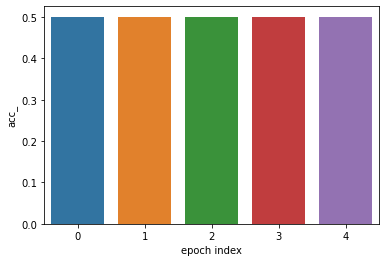

In [20]:
import seaborn as sns
result_df = pd.DataFrame(tot_results)
ax = sns.barplot(x = result_df.index, y = result_df['acc_'])
ax.set_xlabel('epoch index')

Text(0.5, 0, 'epoch index')

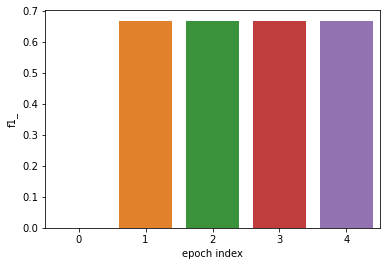

In [21]:
ax = sns.barplot(x = result_df.index, y = result_df['f1_'])
ax.set_xlabel('epoch index')

Text(0.5, 0, 'epoch index')

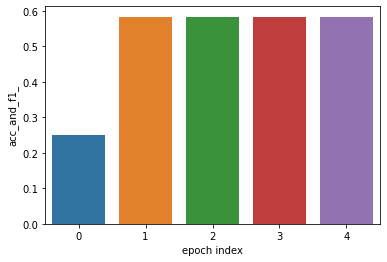

In [22]:
ax2 = sns.barplot(x = result_df.index, y = result_df['acc_and_f1_'])
ax2.set_xlabel('epoch index')

In [18]:
# Optional part 3 goes here
# To measure the impact on NDCG, 
# we'll need to calculate the different bi-encoders' relevance estimates to different files to use in Part 2. 
# You'll need to add more code that loads in each of these models from the checkpoint directories 
# and runs the inference
tot_rel = []
for idx in range(int(args.num_train_epochs)):
    checkpoint = os.path.join(args.output_dir, 'epoch_model_{}'.format(idx))
    
    print(checkpoint)
    model = model_class.from_pretrained(checkpoint)
    model.to(args.device)
    
    model.eval()
    eval_dataset, instances = load_and_cache_examples(args, "codesearch", tokenizer, ttype='test')
    eval_sampler = SequentialSampler(eval_dataset)
    eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=args.eval_batch_size)

    relevance_predictions = np.array([])

    for batch in tqdm(eval_dataloader, desc="Evaluating"):
        batch = tuple(t.to(args.device) for t in batch)
        
        with torch.no_grad():
            inputs = {'query_token_ids': batch[0],
                      'code_token_ids': batch[1],
                      'labels': batch[3]}
            outputs = model(**inputs)
        
        # Let's pull out just the cosine similarity
        _, cosine_sim = outputs[:2] 
        cosine_sims = cosine_sim.cpu().numpy()
    
        # Add these similarities to our current similarities
        relevance_predictions = np.append(relevance_predictions, cosine_sims, axis=0)

    if not os.path.exists(args.test_result_dir):
        os.makedirs(args.test_result_dir)

    output_test_file = os.path.join(args.test_result_dir, 'relevance-scores_{}.csv'.format(idx))

    with open(output_test_file, "w") as outf:
        logger.info("***** Writing relevance predictions *****")
        all_logits = relevance_predictions.tolist()
    
        # Note that we write these all as one big list. In the next step,
        # we'll merge these with the data frame
        outf.write(",".join([str(item) for item in all_logits]))
    
    tot_rel.append(relevance_predictions)

./models/epoch_model_0


12/06/2022 13:27:27 - INFO - run_classifier -   Loading features from cached file ./data/cached_test_test_data_pytorch_model.bin_200_codesearch
12/06/2022 13:27:30 - INFO - utils -   LOOKING AT ./data/test_data.txt
Evaluating: 100%|██████████| 1482/1482 [05:26<00:00,  4.54it/s]
12/06/2022 13:32:58 - INFO - __main__ -   ***** Writing relevance predictions *****


./models/epoch_model_1


12/06/2022 13:33:01 - INFO - run_classifier -   Loading features from cached file ./data/cached_test_test_data_pytorch_model.bin_200_codesearch
12/06/2022 13:33:04 - INFO - utils -   LOOKING AT ./data/test_data.txt
Evaluating: 100%|██████████| 1482/1482 [05:26<00:00,  4.54it/s]
12/06/2022 13:38:32 - INFO - __main__ -   ***** Writing relevance predictions *****


./models/epoch_model_2


12/06/2022 13:38:34 - INFO - run_classifier -   Loading features from cached file ./data/cached_test_test_data_pytorch_model.bin_200_codesearch
12/06/2022 13:38:37 - INFO - utils -   LOOKING AT ./data/test_data.txt
Evaluating: 100%|██████████| 1482/1482 [05:26<00:00,  4.54it/s]
12/06/2022 13:44:06 - INFO - __main__ -   ***** Writing relevance predictions *****


./models/epoch_model_3


12/06/2022 13:44:08 - INFO - run_classifier -   Loading features from cached file ./data/cached_test_test_data_pytorch_model.bin_200_codesearch
12/06/2022 13:44:11 - INFO - utils -   LOOKING AT ./data/test_data.txt
Evaluating: 100%|██████████| 1482/1482 [05:26<00:00,  4.54it/s]
12/06/2022 13:49:39 - INFO - __main__ -   ***** Writing relevance predictions *****


./models/epoch_model_4


12/06/2022 13:49:42 - INFO - run_classifier -   Loading features from cached file ./data/cached_test_test_data_pytorch_model.bin_200_codesearch
12/06/2022 13:49:45 - INFO - utils -   LOOKING AT ./data/test_data.txt
Evaluating: 100%|██████████| 1482/1482 [05:26<00:00,  4.54it/s]
12/06/2022 13:55:13 - INFO - __main__ -   ***** Writing relevance predictions *****


In [19]:
# In the Part 4, just write the different models' predictions to separate files. 
# You might combine this with the part 3 code if it's easier to do there. 
# We haven't marked a spot for it explicitly, but you'll use these files in part 2.

df = pd.read_csv('data/test_data.csv').rename(columns = {'Query_id': 'qid', 'Doc_id':'docno'})
for idx in range(int(args.num_train_epochs)):
    df_temp = df.copy()
    df_temp['sim'] = tot_rel[idx]
    df_temp[["sim",'qid','docno']].to_csv('results/test_relevance_{}.csv'.format(idx))